# 1. Introduction

This notebook provides an analysis on crimes across different communities within the United States. We aim to model the crime rate per community based on a set of predictive attributes.

## 1.1. Importing libraries

In [1]:
"""
Required Libraries:

* numpy
* pandas
* tabulate
* seaborn
* scipy
* geopy
* sklearn
* matplotlib
* statsmodels

""";

In [3]:
from collections import Counter

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import norm
from scipy import stats

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random

seed = 1995

## 1.2. Loading data

As a first step we load the data and take a quick look at the preview of the first five rows.

In [3]:
raw_df = pd.read_csv("data/crime_prep.txt")
raw_df.head()

,target,v_cont_0,v_cat_0,v_cat_1,v_cat_2,v_cat_3,v_cont_5,v_cont_6,v_cont_7,v_cont_8,...,v_cont_117,v_cont_118,v_cont_119,v_cont_120,v_cont_121,v_cont_122,v_cont_123,v_cont_124,v_cont_125,v_cont_126
0,0.20,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,...,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14
1,0.67,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,...,NaN,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN
2,0.43,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,...,NaN,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN
3,0.12,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,...,NaN,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN
4,0.03,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,...,NaN,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN


In [4]:
print(f"The dataset contains {raw_df.shape[0]} columns, and {raw_df.shape[1]} rows.")

The dataset contains 1994 columns, and 128 rows.


From the preview above, we see that the raw data has missing values as it is usually the case for real world datasets. Some columns are categorical whilst others are numerical. 

We also notice that the column names are encoded. We will assume that the columns in this file are in the same order *(except for target variable)* as listed in file **communities.names** to get some contextual meaning on the values. (Assumption validated using given statistics)

The column names are extracted from file **communities.names** and stored, in the same order, in file **data/headers.txt**. This file will be used to rename the headers.

In [5]:
raw_df.columns = [
    col_name for col_name in open("data/headers.txt", "r").read().split("\n")
]
raw_df.head()

,ViolentCrimesPerPop,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
0,0.20,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,...,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14
1,0.67,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,...,NaN,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN
2,0.43,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,...,NaN,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN
3,0.12,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,...,NaN,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN
4,0.03,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,...,NaN,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN


In [6]:
nominal_variables = ["state", "county", "community", "communityname", "fold"]

Now that columns names are meaningful, in the next section we will dive deeply into the data for further analysis.

# 2. Exploratory Data Analysis & Preprocessing

Let's start with a high level exploration.
## 2.1. Missing Data

<AxesSubplot:>

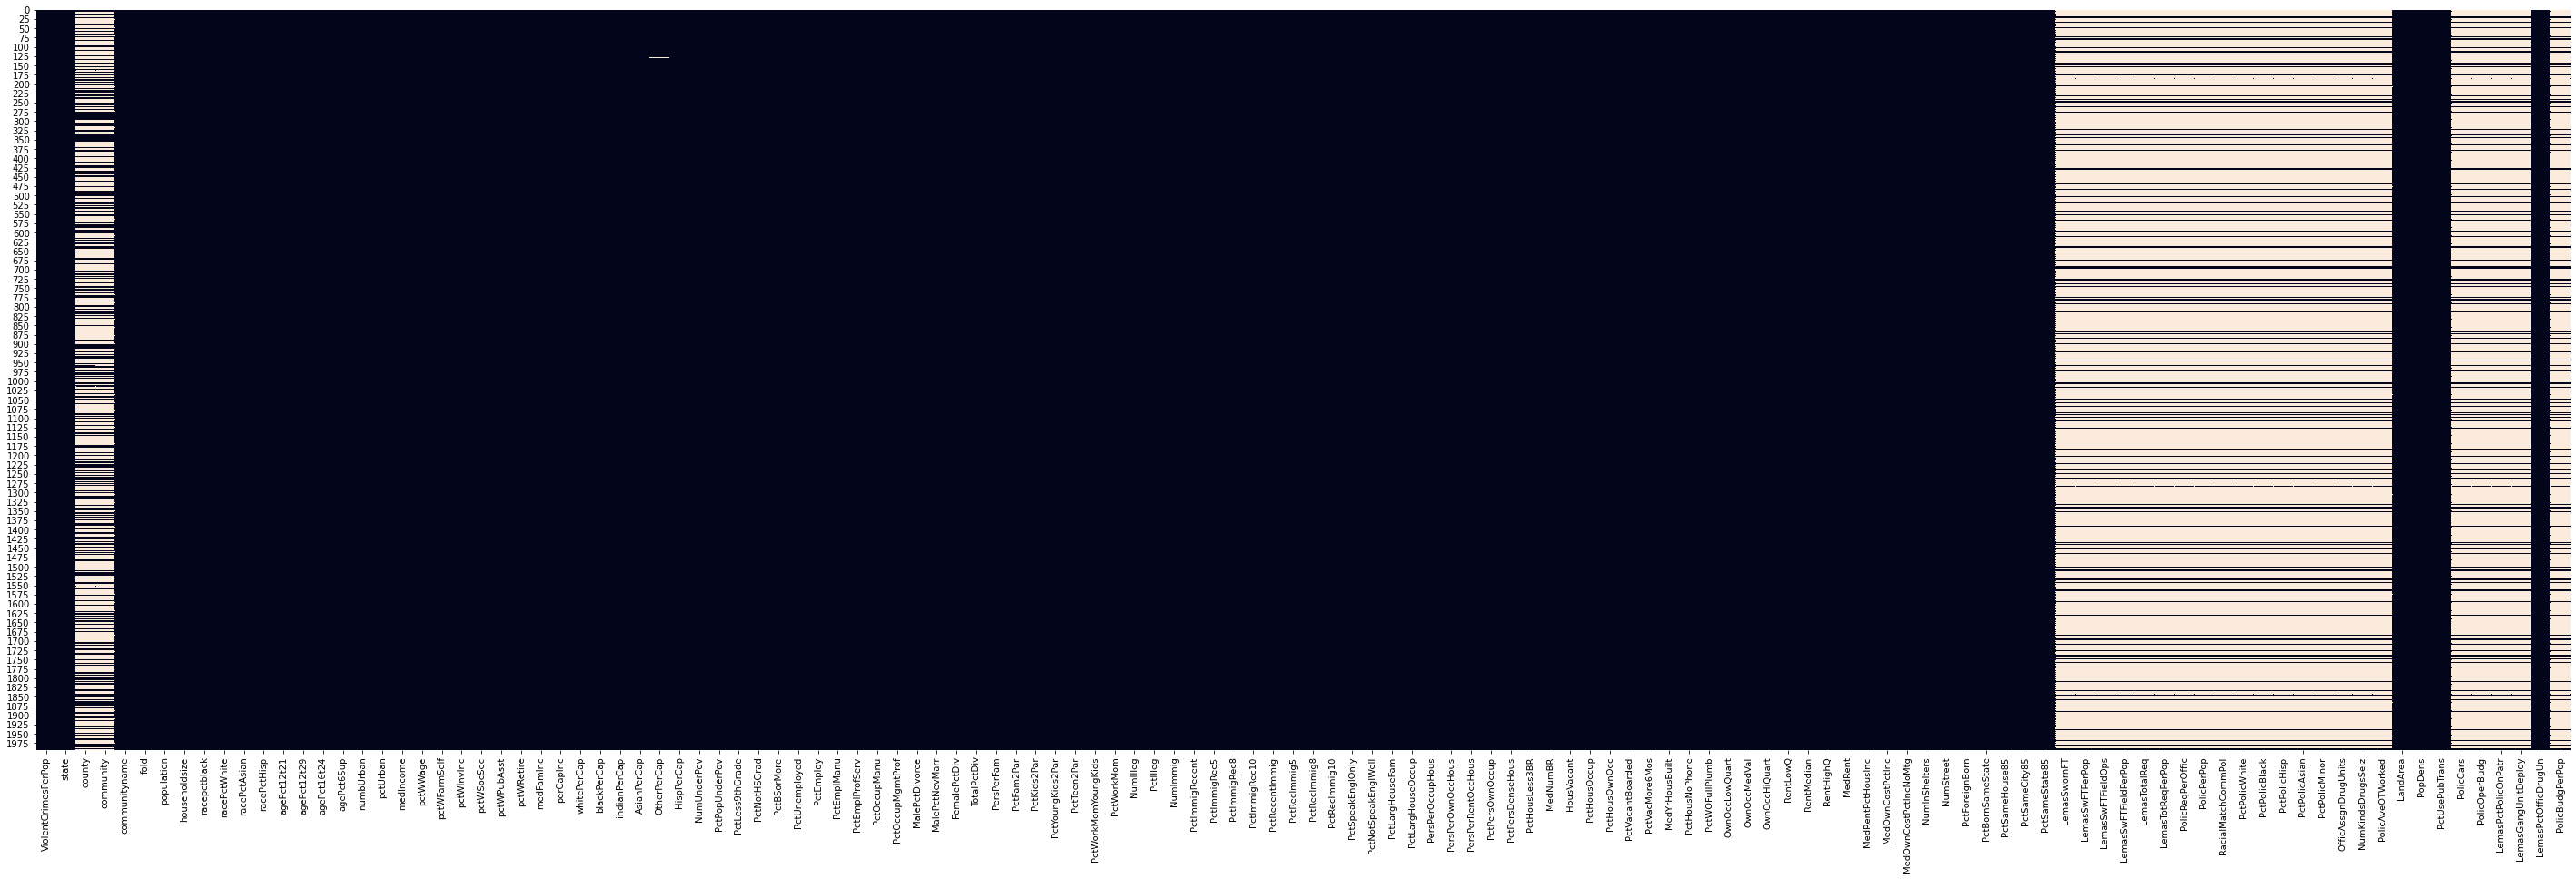

In [7]:
plt.figure(figsize=(50,15))
sns.heatmap(raw_df.isna(), cbar=False)

The heatmap above shows that missing data across all variables (except county and community) has the same pattern. Based on the metadata of this dataset, the reason for having missing records is that the LEMAS survey was only done with Police departments with 100 or more officers.

The county and community variables also have more than 50% missing data. However, these variables will not be considered as predictive variables.

## 2.2. Statistical Description

The following table will give a first hint on the data distribution:

In [8]:
pd.set_option('display.max_rows', raw_df.shape[1])

vars_stats = raw_df[raw_df.columns.difference(nominal_variables)].describe().T
vars_stats["skewness"] = raw_df.skew()

vars_stats.sort_values("skewness")

,count,mean,std,min,25%,50%,75%,max,skewness
LemasSwFTFieldOps,319.0,0.924734,0.132249,0.0,0.9300,0.970,0.9800,1.0,-5.052341
PctSpeakEnglOnly,1994.0,0.785903,0.226869,0.0,0.7300,0.870,0.9400,1.0,-1.943378
LemasPctPolicOnPatr,319.0,0.698589,0.213944,0.0,0.6200,0.750,0.8400,1.0,-1.589877
PctHousOccup,1994.0,0.719549,0.194024,0.0,0.6300,0.770,0.8600,1.0,-1.584067
PctPolicWhite,319.0,0.726959,0.221409,0.0,0.6200,0.780,0.8900,1.0,-1.317389
racePctWhite,1994.0,0.753716,0.244039,0.0,0.6300,0.850,0.9400,1.0,-1.300489
PctSameState85,1994.0,0.651530,0.198221,0.0,0.5600,0.700,0.7900,1.0,-1.295042
PctSameCity85,1994.0,0.626424,0.200521,0.0,0.5200,0.670,0.7700,1.0,-1.024146
RacialMatchCommPol,319.0,0.689404,0.226811,0.0,0.5600,0.740,0.8600,1.0,-0.886763
pctUrban,1994.0,0.696269,0.444811,0.0,0.0000,1.000,1.0000,1.0,-0.885635


In [9]:
Counter(raw_df.describe().T["count"])

Counter({1994.0: 102, 820.0: 1, 817.0: 1, 1993.0: 1, 319.0: 22})

We note the following:
* We observe that most of the variables (103 variables) have complete data whilst few (22 variables) have significant portion of values missing.
* As noted on file **communities.names**, numerical variables are normalized.
* Some variables are highly skewed to the left, we note few: 
| variable Name | Skewness | Possible Explanation |
|---------------|----------|-------------|
| population| left| Most communities are small|
| pctUrban| right| Most people across communities reside in urban areas|
| numbUrban| left| Communities varie significantly in size and most of them are small|
| NumUnderPov, NumIlleg, NumImmig| left| Most communities are small |
| LemasPctOfficDrugUn| left| Mostly small drug-units across communities|
| PolicOperBudg| left| Most communities have low budget for police operations|
| LandArea| left| Most communities have small surface area|
| NumStreet| left| Most communities have low homeless people on street|
| NumInShelters| left| Most communities have low number of homeless people in shelters|
| HousVacant| left| Most households are occupied across communities|

* The LEMAS survey is missing for 1675 communities which accounts for ~80% of records, we will drop these variables from the dataset.

In [10]:
vars2drop = raw_df.describe().T["count"]<400
vars2drop = vars2drop[vars2drop].index
vars2drop

Index(['LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps',
       'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop',
       'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol',
       'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian',
       'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz',
       'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
       'LemasGangUnitDeploy', 'PolicBudgPerPop'],
      dtype='object')

In [11]:
raw_df.drop(vars2drop, 1, inplace= True)

In [12]:
highly_skewed_vars = vars_stats.index[(vars_stats.skewness.abs()>1) & ~vars_stats.index.isin(vars2drop)]
moderately_skewed_vars = vars_stats.index[(0.5<vars_stats.skewness.abs()) & (vars_stats.skewness.abs()<1) & ~vars_stats.index.isin(vars2drop)]

print(f"# of variables with High degree of skewness .abs()>1: {len(highly_skewed_vars)}")
print(f"# of variables with Moderate degree of skewness 0.5<.abs()<1: {len(moderately_skewed_vars)}")

# of variables with High degree of skewness .abs()>1: 53
# of variables with Moderate degree of skewness 0.5<.abs()<1: 26


The data present high levels of skewness, we may consider some transformations to reduce the level of skewness. Multiple transformation can be used to reduce skewness: log transformation, sqrt transformation or box-cox transformation.

## 2.3 ScatterPlots

We've analysed some of the direct relationships between predictive variables and target variable. We list a few:

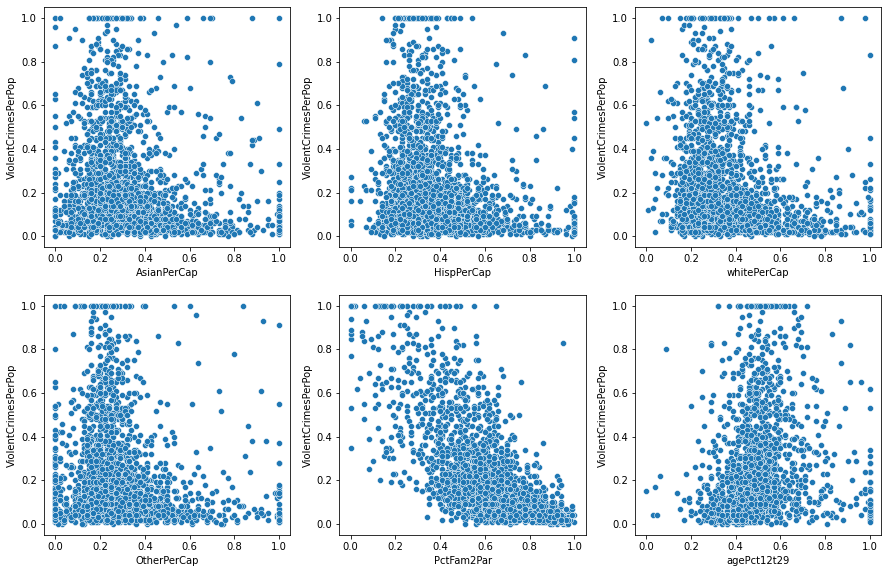

In [13]:
vars2plot = ["AsianPerCap", "HispPerCap", "whitePerCap", "OtherPerCap", "PctFam2Par", "agePct12t29"]
n_vars = len(vars2plot)

n_plot_cols = 3
n_plot_rows = n_vars//n_plot_cols + 1

plt.figure(figsize=(5*n_plot_cols, 5*n_plot_rows))

for r in range(n_vars):
    plt.subplot(n_plot_rows,n_plot_cols,r+1)
    sns.scatterplot(data=raw_df, x=vars2plot[r], y='ViolentCrimesPerPop')
plt.plot();

These scatter plots show that most violent crimes have tendency to happen in communities with low income per capita independently from their ethnicity. We also note that Violent Crimes are significantly reduced in communities with higher percentage of two parents families.

## 2.4 Target Variable Distribution

As we saw in the previous section, even the target variable present a high level of skewness. We will perfom the cox-box transformation to reduce it's skewness.

In [14]:
print(f"Skewness level of target variable: {vars_stats.loc['ViolentCrimesPerPop', 'skewness']}")

Skewness level of target variable: 1.522598485536617


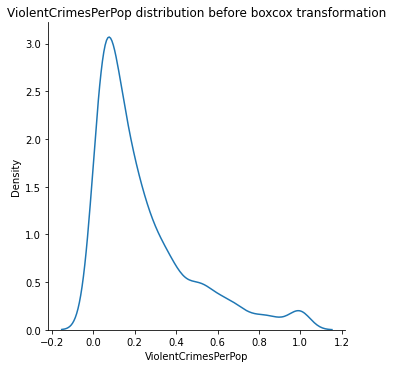

In [15]:
sns.displot(raw_df.ViolentCrimesPerPop, kind="kde")
plt.title("ViolentCrimesPerPop distribution before boxcox transformation");

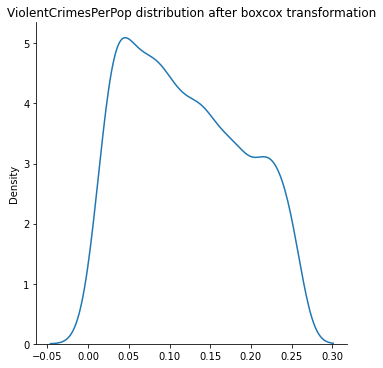

In [16]:
sns.displot(stats.boxcox(raw_df.ViolentCrimesPerPop+1)[0], kind="kde")
plt.title("ViolentCrimesPerPop distribution after boxcox transformation");

In [17]:
print(f"Skewness level of target variable with boxcox transformation: {stats.skew(stats.boxcox(raw_df.ViolentCrimesPerPop+1)[0])}")

Skewness level of target variable with boxcox transformation: 0.2594336654833021


Using the boxcox transformation we can signficantly reduce the skewness on target variable.

## 2.5 Should we consider state as a predictive variable?

To answer this question, we will plot a boxplot for violent crimes per state.

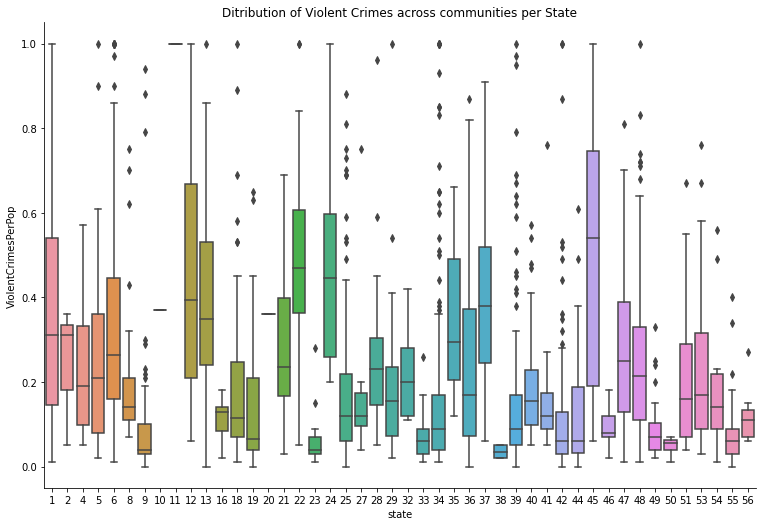

In [18]:
sns.catplot(x="state", 
            y="ViolentCrimesPerPop",
            kind="box",
            height=7, 
            aspect=1.5,
            data=raw_df)
plt.title("Ditribution of Violent Crimes across communities per State");

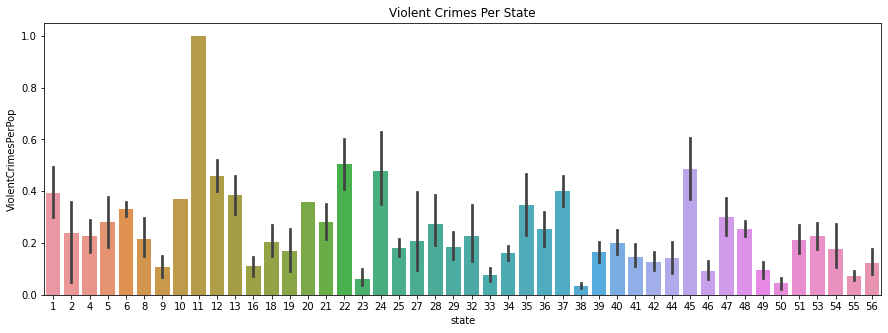

In [19]:
fig = plt.figure(figsize = (15, 5))
sns.barplot(x="state", 
            y="ViolentCrimesPerPop",
            data=raw_df)
plt.title("Violent Crimes Per State");

We note that Violent Crime rates are significantly low in some states compared to others. We may want to include this variable in our modeling. It would also be interesting to try to identify these states using community names and reverse engineer the coordinates to consider them as additional features for our model.

## 2.6 Correlation with Target variable

In this section we will evaluate the 20 most correlated variables with target variable. We will consider for this analysis the boxcox transformation of the target variable.

<AxesSubplot:>

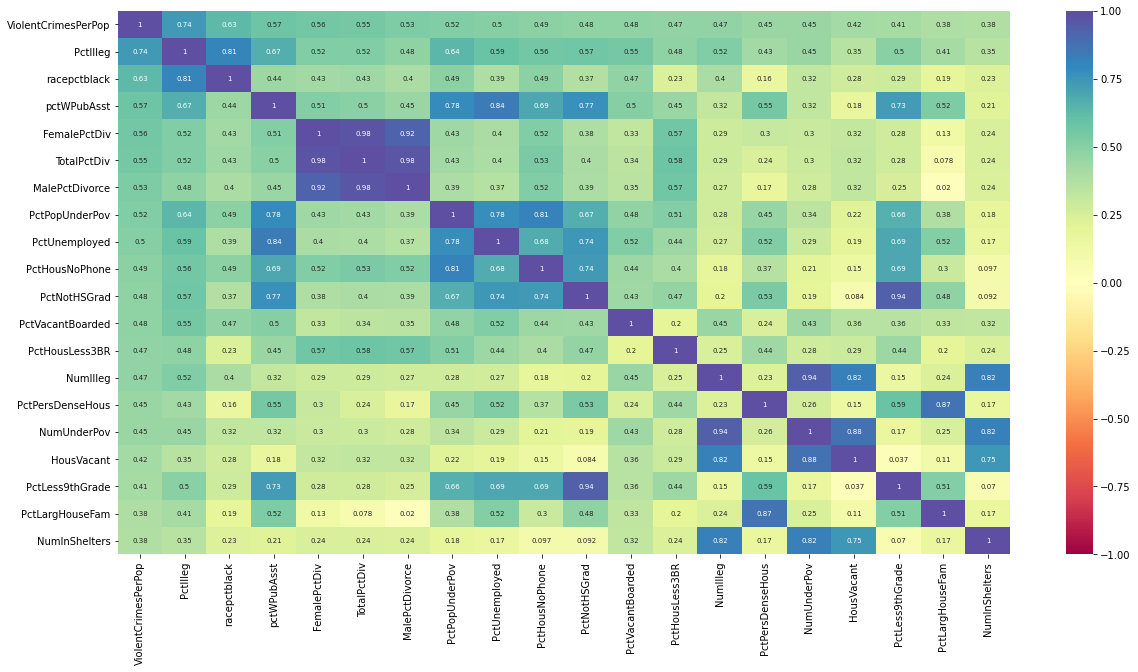

In [20]:
plt.figure(figsize=(20,10))

corr_df = raw_df[raw_df.columns.difference(nominal_variables)].copy()

corr = corr_df.corr()
k = 20
cols = corr.nlargest(k, 'ViolentCrimesPerPop')['ViolentCrimesPerPop'].abs().sort_values(ascending=False).index
sns.heatmap(corr.loc[cols, cols],annot=True,annot_kws={"size": 7},vmin=-1.0, vmax=1.0,cmap="Spectral")


From the correlation plot we notice the existance of multicollenearities amongst predictive variables (pctWPubAsst, FemalePctDiv and TotalPctDiv). We also not the five most correlated variables with target variable:

* **PctIlleg**: percentage of kids born to never married
* **racepctblack**: percentage of population that is african american
* **pctWPubAsst**: percentage of households with public assistance income
* **FemalePctDiv**: percentage of females who are divorced
* **TotalPctDiv**: percentage of population who are divorced


Text(0.5, 0, 'Percentage of Kids Born to never married')

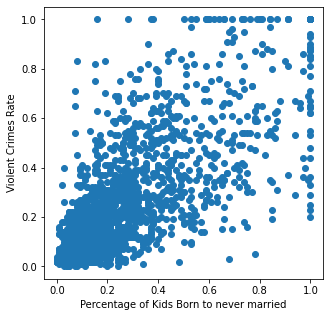

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(raw_df.PctIlleg, corr_df.ViolentCrimesPerPop)
plt.ylabel("Violent Crimes Rate")
plt.xlabel("Percentage of Kids Born to never married")

Although the scatter plot is a bit noisy we see evidence of a relationship between ViolentCrimesPerPop & PctIlleg.

## 2.7. Multicollinearities

One assumption that is made when using Linear Models is that Predictive variables are linearly independent. However, most datasets are not perfect and suffer from multicollinearities. We will evaluate here if that's the case for our dataset.

In [23]:
vif_df = raw_df[raw_df.columns.difference(nominal_variables + ["ViolentCrimesPerPop"])].copy().dropna()

vif_data = pd.DataFrame()
vif_data["column_name"] = vif_df.columns
vif_data["vif"] = list(map(lambda i: variance_inflation_factor(vif_df.values, i), range(len(vif_df.columns))))

In [24]:
vif_data.sort_values("vif", ascending = False).head(10)

,column_name,vif
75,TotalPctDiv,8553.078673
33,PctHousOwnOcc,5373.950088
48,PctPersOwnOccup,5212.454604
1,FemalePctDiv,2927.333029
68,PersPerOccupHous,1728.648600
6,MalePctDivorce,1716.856048
22,OwnOccMedVal,1325.105701
28,PctFam2Par,1207.205258
39,PctKids2Par,1137.505060
67,PersPerFam,849.316195


As we note above, most of the variables have significantly high VIF values (>10) which concludes the existance of multi-collinearities in the data. This conclusion was expected given that most the variables were engineered from the same data and share statistical ranges and trends.

Given the high dimensionality aspect of this dataset it would make sense to use dimensioanlity reduction or regression models with feature selection capabilities such as Lasso using regularization or Tree based algorithms.

# 3. Additional Preprocessing

In [25]:
# drop county + community + fold variables
raw_df.drop(["county", "community", "fold"], 1, inplace=True)

In [26]:
print(f"# of missing values {raw_df.isna().sum().sum()}")

# of missing values 1


We only have one missing value in the database. We can either drop the entire line or fill it with a value. The missing value occured on column 'OtherPerCap'. We can safely impute it with 0 as this will not impact the model.

In [27]:
raw_df.fillna(0, inplace = True)

In [28]:
raw_df.shape

(1994, 103)

# 4. Feature Engineering

In this section we will mostly tranform State with One Hot Encoding.

In [29]:
raw_df.head()

,ViolentCrimesPerPop,state,communityname,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,0.20,8,Lakewoodcity,0.19,0.33,0.02,0.90,0.12,0.17,0.34,...,0.0,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32
1,0.67,53,Tukwilacity,0.00,0.16,0.12,0.74,0.45,0.07,0.26,...,0.0,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00
2,0.43,24,Aberdeentown,0.00,0.42,0.49,0.56,0.17,0.04,0.39,...,0.0,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00
3,0.12,34,Willingborotownship,0.04,0.77,1.00,0.08,0.12,0.10,0.51,...,0.0,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00
4,0.03,42,Bethlehemtownship,0.01,0.55,0.02,0.95,0.09,0.05,0.38,...,0.0,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00


In [30]:
df = pd.get_dummies(raw_df, columns=["state"], drop_first = True)
df.head()

,ViolentCrimesPerPop,communityname,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,state_46,state_47,state_48,state_49,state_50,state_51,state_53,state_54,state_55,state_56
0,0.20,Lakewoodcity,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,...,0,0,0,0,0,0,0,0,0,0
1,0.67,Tukwilacity,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,...,0,0,0,0,0,0,1,0,0,0
2,0.43,Aberdeentown,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,...,0,0,0,0,0,0,0,0,0,0
3,0.12,Willingborotownship,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,...,0,0,0,0,0,0,0,0,0,0
4,0.03,Bethlehemtownship,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,...,0,0,0,0,0,0,0,0,0,0


Other features that can be considered:

* unskewed predictive attributes
* Whether community is in a city or a town.
* Get Coordinates of location using code below:

In [31]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="crime-analysis")
location = geolocator.geocode("Willingboro")

for attr in ["latitude", "longitude", "address"]:
    print(f"{attr:10s}: {getattr(location, attr)}")

latitude  : 40.0278894
longitude : -74.8690542
address   : Willingboro, Willingboro Township, Burlington County, New Jersey, 08046, United States


# 5. Modeling

In this section we will train multiple regression models and compare their performence. As the R-Squared validity is only limited for linear models we will only considere RMSE as a base for comparaison.

We start with splitting the data: 90% of the data will be used to develop the models and optimize their hyper parameters. 10% will be used to validate the final model.

In [32]:
X = df.drop(["communityname", "ViolentCrimesPerPop"], 1)
y = df["ViolentCrimesPerPop"]

# we use a random split with a validation set with 10% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=seed, shuffle=True)

We will train three types of models:
- a linear model with an l1 regularization term (Lasso)
- A Tree based model (Random Forest)
- Support Victors based Model

The three models will be trained with and without dimensionality reduction techniques.

## 5.1. Models without dimensionality reduction

### 5.1.1. Linear Regression

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lr_parameters = {
    'reg__alpha': (0, 1e-4, 0.001, 0.005, 0.01, 0.05, .1, .3, .5, .7, 1), # the l1 coef
}

lr_pipeline = Pipeline([
    ('reg', Lasso(random_state = seed))
])

lr_grid_search = GridSearchCV(lr_pipeline, lr_parameters, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1)

lr_grid_search.fit(X_train, y_train);

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  55 | elapsed:    3.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    3.7s finished


In [35]:
print("Best RMSE score:", -lr_grid_search.best_score_)
print("Best Parameters:", lr_grid_search.best_params_)

Best RMSE score: 0.13130859935580103
Best Parameters: {'reg__alpha': 0.0001}


### 5.1.2. RandomForest

In [36]:
from sklearn.ensemble import RandomForestRegressor

rf_parameters = {
    'reg__n_estimators': (100, 200, 400),
    'reg__max_features': (20, 30, 40),
    'reg__max_depth': (30, 50, 100),
}

rf_pipeline = Pipeline([
    ('reg', RandomForestRegressor(random_state = seed))
])

rf_grid_search = GridSearchCV(rf_pipeline, rf_parameters, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1)

rf_grid_search.fit(X_train, y_train);

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  3.4min finished


In [37]:
print("Best RMSE score:", -rf_grid_search.best_score_)
print("Best Parameters:", rf_grid_search.best_params_)

Best RMSE score: 0.1357034062940626
Best Parameters: {'reg__max_depth': 50, 'reg__max_features': 40, 'reg__n_estimators': 400}


### 5.1.3 SVM Regressor

In [38]:
from sklearn.svm import SVR

svr_parameters = {
    'reg__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
    'reg__degree': (2, 3),
    'reg__C': (0.1, 0.3, 1, 3, 10, 30, 100)
}

svr_pipeline = Pipeline([
    ('reg', SVR())
])

svr_grid_search = GridSearchCV(svr_pipeline, svr_parameters, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1)

svr_grid_search.fit(X_train, y_train);

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  2.8min finished


In [39]:
print("Best RMSE score:", -svr_grid_search.best_score_)
print("Best Parameters:", svr_grid_search.best_params_)

Best RMSE score: 0.12901401705111287
Best Parameters: {'reg__C': 0.3, 'reg__degree': 2, 'reg__kernel': 'poly'}


The SVM Regressor presented slighted better RMSE score compared to the previous two models.

## 5.2. Models with dimensionality reduction

In this section we considered dimensionality reduction using PCA, we use cross-validation to determine the number of componentes to retain (% of variance).

### 5.2.1. Linear Regression

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

lr_dr_parameters = {
    'dim__n_components': [0.8, 0.9, 0.95, 0.99],
    'reg__alpha': (0, 1e-4, 0.001, 0.005, 0.01, 0.05, .1, .3, .5, .7, 1), # the l1 coef
}

lr_dr_pipeline = Pipeline([
    ('dim', PCA()),
    ('reg', Lasso(random_state = seed))
])

lr_dr_grid_search = GridSearchCV(lr_dr_pipeline, lr_dr_parameters, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1)

lr_dr_grid_search.fit(X_train, y_train);

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    6.0s finished


In [42]:
print("Best RMSE score:", -lr_dr_grid_search.best_score_)
print("Best Parameters:", lr_dr_grid_search.best_params_)

Best RMSE score: 0.13240190716016087
Best Parameters: {'dim__n_components': 0.99, 'reg__alpha': 0.0001}


### 5.2.2. RandomForest

In [43]:
from sklearn.ensemble import RandomForestRegressor

rf_dr_parameters = {
    'dim__n_components': [0.8, 0.9, 0.95, 0.99],
    'reg__n_estimators': (100, 200, 400),
    'reg__max_features': (20, 30, 40),
    'reg__max_depth': (30, 50, 100),
}

rf_dr_pipeline = Pipeline([
    ('dim', PCA()),
    ('reg', RandomForestRegressor(random_state = seed))
])

rf_dr_grid_search = GridSearchCV(rf_dr_pipeline, rf_dr_parameters, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1)

rf_dr_grid_search.fit(X_train, y_train);

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 17.2min finished


In [44]:
print("Best RMSE score:", -rf_dr_grid_search.best_score_)
print("Best Parameters:", rf_dr_grid_search.best_params_)

Best RMSE score: 0.13983579645286062
Best Parameters: {'dim__n_components': 0.8, 'reg__max_depth': 30, 'reg__max_features': 20, 'reg__n_estimators': 200}


### 5.2.3 SVM Regressor

In [45]:
from sklearn.svm import SVR

svr_dr_parameters = {
    'dim__n_components': [0.8, 0.9, 0.95, 0.99],
    'reg__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
    'reg__degree': (2, 3),
    'reg__C': (0.1, 0.3, 1, 3, 10, 30, 100)
}

svr_dr_pipeline = Pipeline([
    ('dim', PCA()),
    ('reg', SVR())
])

svr_dr_grid_search = GridSearchCV(svr_dr_pipeline, svr_dr_parameters, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1)

svr_dr_grid_search.fit(X_train, y_train);

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:  7.1min finished


In [46]:
print("Best RMSE score:", -svr_dr_grid_search.best_score_)
print("Best Parameters:", svr_dr_grid_search.best_params_)

Best RMSE score: 0.13267649639095622
Best Parameters: {'dim__n_components': 0.99, 'reg__C': 0.3, 'reg__degree': 2, 'reg__kernel': 'rbf'}


We didn't see signficant improvement with dimensionality reduction. feature Selection can also be explored.

## 5.3. Summary

Sometimes using cross-validation to compare models may give instable outputs because we can get lucky on the model's performance results. To remediate to this problem cross-validation with boostraping can be used where we sample 90% of records as training data (with replacement) 20, 30 or even 100 times to get an accurate estimate on the model's performance.

Developing a model is never sequential, instead it is an iterative process where every step in the pipeline can be revisited more than once.

After assessing the performance of models through cross-validation, we perform the boxcox transformation to continue our modeling. However, we didn't see a significant improvement on models performance.

Even with dimensionality reduction, we didn't get better performance. We assume that further transformations (log, coxbox, polynomial...) may be required on predictive variables to "help" models capture more variance of the target variable.

The evaluation of models performance is based on the root mean squared error. The `Support Victor Machine` Model outperformed all the other models on the validation sets with an rmse score of 0.129:

In [47]:
svr_grid_search.best_estimator_

Pipeline(steps=[('reg', SVR(C=0.3, degree=2, kernel='poly'))])

# 6. Final Model Testing

After determining the best performing model using cross-validation, it is time to evaluate how the selected model would perform on unseen data, aka the test data. we will train the model on the whole training set one more time then we will evaluate its performance on the test data:

In [49]:
# fit models with best paramters on the whole training set:
svr_grid_search.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('reg', SVR(C=0.3, degree=2, kernel='poly'))])

In [53]:
from sklearn.metrics import mean_squared_error

y_pred = svr_grid_search.best_estimator_.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Performance evalution of the SVR Model on testing data: {test_rmse:.4f}")

Performance evalution of the SVR Model on testing data: 0.1169


The test score is close to the validation score which concludes that there's no overfitting.

# Conclusion:

In this project, we detailed different steps to train a regression model to predict Violent Crimes based on Communites Statistics, Demographical and Economical characteristics. The steps includes:
- Data Import: in which we handled data formating.
- Exploratory Data Analysis: that consisted on performing an in depth analysis on the dataset.
- Data Preprocessing: in which missing values and non predictive variables are handled
- Feature Engineering: More features were generated in this step.
- Modeling: through this step, models were trained with and without dimensionality reduction. There is still room for improvement, for instance other dimensionality reduction technique can be considered as well as feature selection. Additional transformations can be used on the predictive variables as well to reduce skewness in data. Another suggestion would be to use an ensemble model by combining two or more uncorrelated models.
